In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import combinations
import matplotlib.font_manager as fm
import platform
import seaborn as sns

In [2]:
# 데이터 불러오기
file_path ="AmesHousing.csv"
df = pd.read_csv(file_path)

# 시스템별 기본 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'    # 맥
else:
    plt.rcParams['font.family'] = 'NanumGothic'     # 리눅스 (예: colab, ubuntu)

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

결측치 처리

In [3]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

edited_df = df

#결측치 80%이상인경우 컬럼 삭제
missing_cols = missing.loc[(missing / len(df)) > 0.80].index
edited_df = edited_df.drop(columns=missing_cols)

missing_cols = missing.loc[(missing / len(df)) < 0.05].index
for col in missing_cols:
    if edited_df[col].dtype == 'object' or edited_df[col].dtype.name == 'category':
        #결측치 5%이하 범주형 변수 최빈값 대체
        edited_df[col] = edited_df[col].fillna(edited_df[col].mode().iloc[0])
    else:
        #결측치 5%이하 수치형 변수 중앙값 대체
        edited_df[col] = edited_df[col].fillna(edited_df[col].median())
        

#수치형은 MICE, 범주형은 'Missing'으로 결측치 채우기
missing_cols = missing.loc[(0.05 <= (missing / len(df))) & ((missing / len(df)) <= 0.80)].index

numeric_cols = edited_df.select_dtypes(include=['number']).columns

for col in missing_cols:
    if edited_df[col].dtype == 'object' or edited_df[col].dtype.name == 'category':
        edited_df[col] = edited_df[col].fillna('Missing')

#MICE Imputation(다중 대체)이용하여 결측치 제거
imputer = IterativeImputer(random_state=0)
edited_df[numeric_cols] = imputer.fit_transform(edited_df[numeric_cols])

상관관계 분석 기반 변수 선택 및 train test 분리

In [4]:
FEATURE_NUM = 10

numeric_df = df.select_dtypes(include='number')
corr_with_target = numeric_df.corr()['SalePrice'].drop('SalePrice').abs()

top_features = corr_with_target.sort_values(ascending=False).head(FEATURE_NUM).index.tolist()
print(f"상관계수 Top {FEATURE_NUM}변수: ", top_features)

X = edited_df.drop('SalePrice', axis=1)[top_features]
y = edited_df['SalePrice']

#train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_const = sm.add_constant(X_train).astype(float)
X_test_const = sm.add_constant(X_test).astype(float)

상관계수 Top 10변수:  ['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Full Bath', 'Year Remod/Add', 'Garage Yr Blt']


초기 회귀모델 생성 및 요약

In [5]:
ols_model = sm.OLS(y_train, X_train_const).fit()

y_pred = ols_model.predict(X_test_const)
pvalues = ols_model.pvalues.drop('const')

#model summary
print(ols_model.summary())

y_pred = ols_model.predict(X_test_const)



r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = X_train_const.shape[-1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"adj R² on test data: {adj_r2:.4f}")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE on test data: {mae:,.2f}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on test data: {rmse:,.2f}")

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     876.1
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:58:50   Log-Likelihood:                -27876.
No. Observations:                2344   AIC:                         5.577e+04
Df Residuals:                    2333   BIC:                         5.584e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.233e+06   9.85e+04    -12.

상관계수 상위 10개 feature를 이용해 다중선형회귀로 학습한 모델 결과 adj R-sqaured = 0.8043, RMSE = 39,238.60 (단위 $)


이후 모든 변수쌍에 대해 interaction 탐색

In [6]:
interactions = []
tmp_df = edited_df.copy()
base_r2 = ols_model.rsquared_adj

for var1, var2 in combinations(X_train.columns, 2):
    tmp_df['interaction'] = tmp_df[var1] * tmp_df[var2]
    
    model = sm.OLS(y, sm.add_constant(tmp_df[[var1, var2, 'interaction']])).fit()
    pval = model.pvalues[('interaction')]
    r2_adj = model.rsquared_adj
    
    if pval < 0.05:
        print(f"상호작용 있음: {var1} * {var2} (p={pval:.4f}, Adjr={r2_adj:.4f})")
        interactions.append((var1, var2, pval, r2_adj))

상호작용 있음: Overall Qual * Gr Liv Area (p=0.0000, Adjr=0.7545)
상호작용 있음: Overall Qual * Garage Cars (p=0.0000, Adjr=0.7410)
상호작용 있음: Overall Qual * Garage Area (p=0.0000, Adjr=0.7320)
상호작용 있음: Overall Qual * Total Bsmt SF (p=0.0000, Adjr=0.7094)
상호작용 있음: Overall Qual * 1st Flr SF (p=0.0000, Adjr=0.7227)
상호작용 있음: Overall Qual * Year Built (p=0.0000, Adjr=0.6745)
상호작용 있음: Overall Qual * Full Bath (p=0.0000, Adjr=0.6905)
상호작용 있음: Overall Qual * Year Remod/Add (p=0.0000, Adjr=0.6786)
상호작용 있음: Overall Qual * Garage Yr Blt (p=0.0000, Adjr=0.6729)
상호작용 있음: Gr Liv Area * Garage Cars (p=0.0000, Adjr=0.6468)
상호작용 있음: Gr Liv Area * Garage Area (p=0.0000, Adjr=0.6178)
상호작용 있음: Gr Liv Area * Total Bsmt SF (p=0.0000, Adjr=0.6453)
상호작용 있음: Gr Liv Area * 1st Flr SF (p=0.0000, Adjr=0.5932)
상호작용 있음: Gr Liv Area * Year Built (p=0.0000, Adjr=0.6716)
상호작용 있음: Gr Liv Area * Year Remod/Add (p=0.0000, Adjr=0.6371)
상호작용 있음: Gr Liv Area * Garage Yr Blt (p=0.0000, Adjr=0.6558)
상호작용 있음: Garage Cars * Garage Area (p=0

In [7]:
INTERACTION_NUM = 30

interactions_sorted = sorted(interactions, key=lambda x: (x[2], -x[3]))  # pval 오름차순, R² 내림차순
top_interactions = [(v1, v2) for v1, v2, _, _ in interactions_sorted[:INTERACTION_NUM]]

X_train_const_interaction = X_train_const.copy()
X_test_const_interaction = X_test_const.copy()

# 상호작용 항 추가 (훈련 데이터)
for var1, var2 in top_interactions:
    X_train_const_interaction[f'{var1}_x_{var2}'] = X_train[var1] * X_train[var2]
    X_test_const_interaction[f'{var1}_x_{var2}'] = X_test[var1] * X_test[var2]

final_model = sm.OLS(y_train, X_train_const_interaction).fit()
print(final_model.summary())

y_pred = final_model.predict(X_test_const_interaction)




r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = X_train_const_interaction.shape[-1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"adj R² on test data: {adj_r2:.4f}")
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE on test data: {mae:,.2f}")
print(f"RMSE on test data: {rmse:,.2f}")

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     380.7
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:58:51   Log-Likelihood:                -27324.
No. Observations:                2344   AIC:                         5.473e+04
Df Residuals:                    2303   BIC:                         5.497e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

위 결과 interaction 항을 추가하면 모델의 성능이 향상되는 모습을 볼 수 있다. (summary의 r2 squared = 0.869, test data에 대한 r2-squared = 0.8590, RMSE= 32,424)

이후 학습된 모델들의 다중공선성을 확인

In [8]:
#기본 상관관계 상위 10개 feature에 대한 VIF분석
vif_df = pd.DataFrame()
vif_df["feature"] = X_train_const.columns
vif_df["VIF"] = [variance_inflation_factor(X_train_const.values, i)
                 for i in range(X_train_const.shape[1])]

print("기본 데이터\n", vif_df)

#interaction 포함 feature에 대한 VIF분석
vif_df_itr = pd.DataFrame()
vif_df_itr["feature"] = X_train_const_interaction.columns
vif_df_itr["VIF"] = [variance_inflation_factor(X_train_const_interaction.values, i)
                 for i in range(X_train_const_interaction.shape[1])]

print("인터렉션 추가 데이터\n", vif_df_itr)




기본 데이터
            feature           VIF
0            const  18107.600105
1     Overall Qual      2.551292
2      Gr Liv Area      2.601161
3      Garage Cars      5.306157
4      Garage Area      5.310741
5    Total Bsmt SF      3.378665
6       1st Flr SF      3.585814
7       Year Built      3.883778
8        Full Bath      2.122178
9   Year Remod/Add      1.896295
10   Garage Yr Blt      4.379177
인터렉션 추가 데이터
                            feature           VIF
0                            const  6.793389e+07
1                     Overall Qual  3.688273e+04
2                      Gr Liv Area  4.118905e+04
3                      Garage Cars  8.837432e+04
4                      Garage Area  8.007096e+04
5                    Total Bsmt SF  5.276991e+04
6                       1st Flr SF  3.888407e+04
7                       Year Built  1.781319e+04
8                        Full Bath  2.618387e+04
9                   Year Remod/Add  5.948742e+01
10                   Garage Yr Blt  1.240831

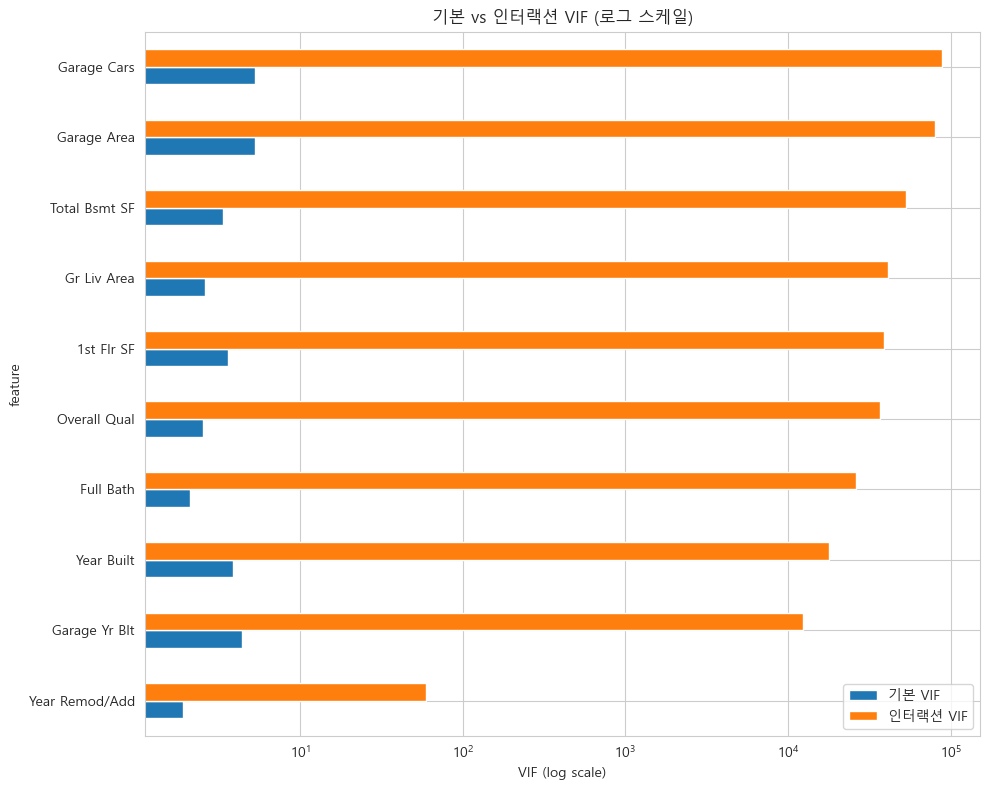

In [9]:
#상수항 제거
vif_df = vif_df[vif_df["feature"] != "const"]
vif_df_itr = vif_df_itr[vif_df_itr["feature"] != "const"]

# 공통 변수만 비교 (두 버전에 모두 존재하는 변수만 추림)
common_features = set(vif_df["feature"]).intersection(set(vif_df_itr["feature"]))

# 두 데이터프레임에서 공통 feature만 추림
vif_base = vif_df[vif_df["feature"].isin(common_features)].set_index("feature")
vif_inter = vif_df_itr[vif_df_itr["feature"].isin(common_features)].set_index("feature")

# 하나로 합치기
vif_compare = pd.DataFrame({
    "기본 VIF": vif_base["VIF"],
    "인터랙션 VIF": vif_inter["VIF"]
}).sort_values("인터랙션 VIF", ascending=True)

# 시각화
vif_compare.plot(kind="barh", figsize=(10, 8), logx=True)
plt.title("기본 vs 인터랙션 VIF (로그 스케일)")
plt.xlabel("VIF (log scale)")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

기존 데이터의 경우 VIF가 모두 10이하로 다중 공선성이 많이 나타나지 않으나,
Interaction feature를 추가한 경우 다중 공선성이 굉장히 크게 증가하여, 해석에 주의가 필요해진다.

여기서부터는 원 핫 인코딩을 사용한 코드

In [10]:
edited_df = pd.get_dummies(edited_df, drop_first=True)

X = edited_df.drop('SalePrice', axis=1)
y = edited_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_const = sm.add_constant(X_train).astype(float)
X_test_const = sm.add_constant(X_test).astype(float)

초기 회귀모델 생성 및 요약

In [11]:
ols_model = sm.OLS(y_train, X_train_const).fit()

y_pred = ols_model.predict(X_test_const)
pvalues = ols_model.pvalues.drop('const')

#model summary
print(ols_model.summary())

y_pred = ols_model.predict(X_test_const)



r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = X_train_const.shape[-1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"adj R² on test data: {adj_r2:.4f}")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE on test data: {mae:,.2f}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on test data: {rmse:,.2f}")

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     106.0
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:58:51   Log-Likelihood:                -26633.
No. Observations:                2344   AIC:                         5.377e+04
Df Residuals:                    2092   BIC:                         5.522e+04
Df Model:                         251                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   9.57

In [12]:
interactions = []
tmp_df = edited_df.copy()
base_r2 = ols_model.rsquared_adj

for var1, var2 in combinations(X_train.columns, 2):
    tmp_df['interaction'] = tmp_df[var1] * tmp_df[var2]
    
    model = sm.OLS(y, sm.add_constant(tmp_df[[var1, var2, 'interaction']].astype(float))).fit()
    pval = model.pvalues[('interaction')]
    r2_adj = model.rsquared_adj
    
    if pval < 0.05:
        print(f"상호작용 있음: {var1} * {var2} (p={pval:.4f}, Adjr={r2_adj:.4f})")
        interactions.append((var1, var2, pval, r2_adj))

상호작용 있음: Order * Year Built (p=0.0014, Adjr=0.3135)
상호작용 있음: Order * BsmtFin SF 1 (p=0.0002, Adjr=0.1908)
상호작용 있음: Order * Total Bsmt SF (p=0.0015, Adjr=0.4013)
상호작용 있음: Order * 1st Flr SF (p=0.0017, Adjr=0.3885)
상호작용 있음: Order * 2nd Flr SF (p=0.0001, Adjr=0.0772)
상호작용 있음: Order * Gr Liv Area (p=0.0136, Adjr=0.5007)
상호작용 있음: Order * Garage Yr Blt (p=0.0003, Adjr=0.3070)
상호작용 있음: Order * Garage Cars (p=0.0067, Adjr=0.4206)
상호작용 있음: Order * Garage Area (p=0.0060, Adjr=0.4111)
상호작용 있음: Order * Open Porch SF (p=0.0005, Adjr=0.1021)
상호작용 있음: Order * Enclosed Porch (p=0.0480, Adjr=0.0177)
상호작용 있음: Order * Pool Area (p=0.0207, Adjr=0.0067)
상호작용 있음: Order * Neighborhood_NoRidge (p=0.0164, Adjr=0.0885)
상호작용 있음: Order * Neighborhood_StoneBr (p=0.0014, Adjr=0.0601)
상호작용 있음: Order * Condition 2_PosN (p=0.0130, Adjr=0.0076)
상호작용 있음: Order * House Style_2Story (p=0.0040, Adjr=0.0481)
상호작용 있음: Order * Exterior 1st_CemntBd (p=0.0034, Adjr=0.0231)
상호작용 있음: Order * Exterior 2nd_CmentBd (p=0.0117, Adjr=0

In [13]:
INTERACTION_NUM = 30

interactions_sorted = sorted(interactions, key=lambda x: (x[2], -x[3]))  # pval 오름차순, R² 내림차순
top_interactions = [(v1, v2) for v1, v2, _, _ in interactions_sorted[:INTERACTION_NUM]]

X_train_const_interaction = X_train_const.copy()
X_test_const_interaction = X_test_const.copy()

# 상호작용 항 추가 (훈련 데이터)
for var1, var2 in top_interactions:
    X_train_const_interaction[f'{var1}_x_{var2}'] = X_train[var1] * X_train[var2]
    X_test_const_interaction[f'{var1}_x_{var2}'] = X_test[var1] * X_test[var2]

all_model = sm.OLS(y_train, X_train_const_interaction.astype(float)).fit()
print(final_model.summary())

y_pred = all_model.predict(X_test_const_interaction)

r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = X_train_const_interaction.shape[-1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"adj R² on test data: {adj_r2:.4f}")
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE on test data: {mae:,.2f}")
print(f"RMSE on test data: {rmse:,.2f}")

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     380.7
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:59:34   Log-Likelihood:                -27324.
No. Observations:                2344   AIC:                         5.473e+04
Df Residuals:                    2303   BIC:                         5.497e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

원 핫 인코딩을 사용한 변수들을 전부 넣은 후, 인터랙션 변수를 추가한 결과 오히려 성능이 떨어지는것이 보인다.

In [16]:
#모든 변수 포함 모델에 대한 VIF분석
vif_df = pd.DataFrame()
vif_df["feature"] = X_train_const.columns
vif_df["VIF"] = [variance_inflation_factor(X_train_const.values, i)
                 for i in range(X_train_const.shape[1])]

print("기본 데이터\n", vif_df)

X_train_const_interaction = X_train_const_interaction.astype('float')
#모든 변수 포함 + interaction 모델에 대한 VIF분석
vif_df_itr = pd.DataFrame()
vif_df_itr["feature"] = X_train_const_interaction.columns
vif_df_itr["VIF"] = [variance_inflation_factor(X_train_const_interaction.values, i)
                 for i in range(X_train_const_interaction.shape[1])]

print("인터렉션 추가 데이터\n", vif_df_itr)




C:\Users\dongbin\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\dongbin\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\dongbin\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


기본 데이터
                     feature         VIF
0                     const    0.000000
1                     Order  168.736050
2                       PID   13.141400
3               MS SubClass   27.735938
4              Lot Frontage    3.264075
..                      ...         ...
253  Sale Condition_AdjLand    1.401820
254   Sale Condition_Alloca    1.545139
255   Sale Condition_Family    1.405901
256   Sale Condition_Normal    3.235863
257  Sale Condition_Partial   39.854227

[258 rows x 2 columns]


C:\Users\dongbin\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\dongbin\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\dongbin\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


인터렉션 추가 데이터
                                     feature           VIF
0                                     const  0.000000e+00
1                                     Order  1.704470e+02
2                                       PID  1.334037e+01
3                               MS SubClass  2.798345e+01
4                              Lot Frontage  3.301528e+00
..                                      ...           ...
283             Garage Yr Blt_x_Garage Area  6.608963e+04
284        Electrical_SBrkr_x_Sale Type_New  4.740631e+14
285            Year Remod/Add_x_Garage Cars  3.011529e+04
286  Central Air_Y_x_Sale Condition_Partial  6.433714e+14
287              Garage Area_x_Bsmt Qual_TA  1.490898e+01

[288 rows x 2 columns]


In [23]:
print(len(vif_df[vif_df["VIF"] > 10]))
print(len(vif_df_itr[vif_df_itr["VIF"] > 10]))

83
119
